**Nota importante:** este kernel es una adaptación del kernel de Kaggle de DLao ubicado en la siguiente dirección web https://www.kaggle.com/laowingkin/netflix-movie-recommendation
Lo usé para poder preprocesar el conjunto de datos GRANDE de Netflix en una manera eficiente sin desperdiciar memoria de la computadora.
Más adelante usaremos la biblioteca LIBMF para hacer las recomendaciones basadas en el conjunto de datos limpio

# Preprocesamiento del dataset del concurso de Netflix para realizar un modelo de recomendación de películas

Este kernel tiene como objetivo limpiar la base de datos de películas de Netflix y darle el formato necesario para que pueda ingresarse a la libreria LIBMF. 

El dataset utilizado se extrajo de Kaggle y está compuesto de 4 archivos de texto (.txt), cada archivo contiene más de 20 millones de filas, es decir, el dataset completo tiene alrededor de 100 Millones de lineas, lo cual representa un reto formidable en terminos computacionales.
Esta información corresponde a los datos de ratings de 17K películas y más de 500K clientes en el perido de 1998 al 2005.

<br>
One of the major challenges is to get all these data loaded into the Kernel for analysis, I have encountered many times of Kernel running out of memory and tried many different ways of how to do it more efficiently. 

Uno de los principales desafíos es cargar todos estos datos en el Kernel para su análisis y limpieza. Si intentamos los mismos métodos propuestos con los datasets de muestra el Kernel se  quedan sin memoria y marca mensajes de error. Por este motivo usamos como referencia el codifo de DLao mencionado anteriormente ya que el propone una solución eficiente.

# Manipulación de datos

## Carga de los Datos

El conjunto de datos del concurso de Netflix tiene 4 archivos .txt, cada uno contiene las siguientes columnas:

* ID de película (como la primera linea de cada registro y marcado con un numero seguido de :)
* ID del cliente
* Calificación (escala del 1 al 5)
* Fecha de la calificación


Importamos e instalamos paquetes necesarios

In [1]:
#instala paquetes que no tengamos
import sys
!{sys.executable} -m pip install surprise

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
#importamos librerias que vamos a usar 
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Carga del primer archivo .txt para medir su tamaño

In [5]:
#hacemos una prueba con el primer archivo txt de 4 que hay que combinar y mostramos un head:
df1 = pd.read_csv('combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df1.head()

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [6]:
#Entender el formato en el que viene la base de datos
df1['Rating'] = df1['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::5000000, :])

Dataset 1 shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


Carga de los 3 datasets restantes al kernel:

In [5]:
df2 = pd.read_csv('../input/combined_data_2.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df3 = pd.read_csv('../input/combined_data_3.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df4 = pd.read_csv('../input/combined_data_4.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])


df2['Rating'] = df2['Rating'].astype(float)
df3['Rating'] = df3['Rating'].astype(float)
df4['Rating'] = df4['Rating'].astype(float)

print('Dataset 2 shape: {}'.format(df2.shape))
print('Dataset 3 shape: {}'.format(df3.shape))
print('Dataset 4 shape: {}'.format(df4.shape))

Dataset 2 shape: (26982302, 2)
Dataset 3 shape: (22605786, 2)
Dataset 4 shape: (26851926, 2)


Concatenamos los conjuntos de datos en un **GRAN DATAFRAME** :

In [6]:
#concatenamos datasets

df = df1
df = df1.append(df2)
df = df.append(df3)
df = df.append(df4)

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Full dataset shape: (100498277, 2)
-Dataset examples-
           Cust_Id  Rating
0               1:     NaN
5000000    2560324     4.0
10000000   2271935     2.0
15000000   1921803     2.0
20000000   1933327     3.0
25000000   1465002     3.0
30000000    961023     4.0
35000000   1372532     5.0
40000000    854274     5.0
45000000    116334     3.0
50000000    768483     3.0
55000000   1331144     5.0
60000000   1609324     2.0
65000000   1699240     3.0
70000000   1776418     4.0
75000000   1643826     5.0
80000000    932047     4.0
85000000   2292868     4.0
90000000    932191     4.0
95000000   1815101     3.0
100000000   872339     4.0


## MINI EDA

Estadísticas básicas sobre el conjunto de datos,
1. Número de películas
2. Número de usuarios
3. Número de calificaciones
4. Gráfico de barras de calificaciones

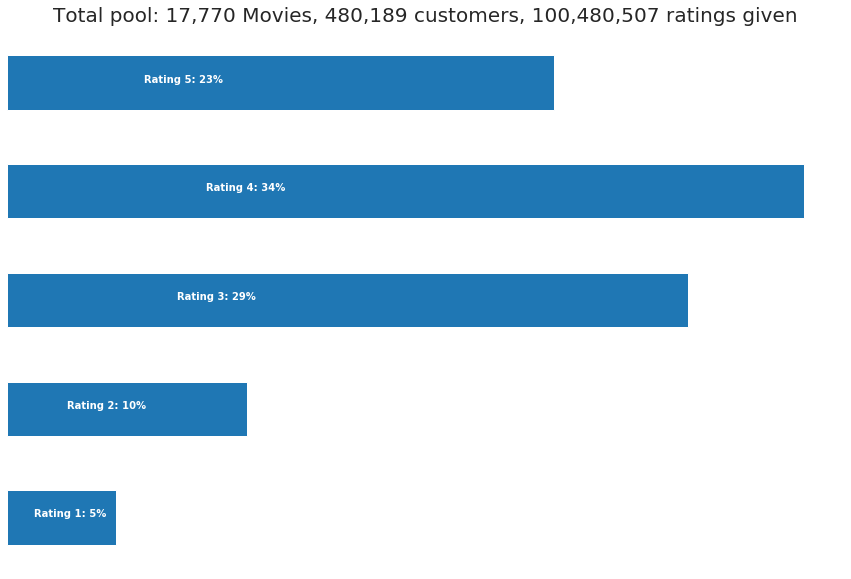

In [7]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# obtenemos el count de las peliculas
movie_count = df.isnull().sum()[1]

# obtener el count de clientes
cust_count = df['Cust_Id'].nunique() - movie_count

# obtener recuento de calificación
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')



Podemos ver que las calificación tiende a ser más positiva (86% esta entre 3-5). Esto podría ser debido a que los usuarios insatisfechos tienden a irse de la plataforma en lugar de calificar.
**Podríamos utilizar esta información más adelante para centralizar las calificaciones.**

## Limpieza del dataset

La parte más dificil de la limpieza de este dataset es corregir los valores de Movie_ID.
Para limpiar la columna Movie_ID se debe de recorrer el dataframe completo varias veces para agregar la columna de ID, lo cual hace que el Kernel se quede sin memoria.
La solución propuesta por DLao es crear primero una matriz numpy con la longitud correcta y luego agregar todo el arreglo como una columna adicional al dataframe.
**Siguiendo el metodo propuesto por DLao y usando una EC2 con 8 VCPUs y 32GB de RAM esta operación se tardó 90 min en completarse.**

In [8]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 1.777e+04 1.777e+04 1.777e+04]
Length: 100480507


In [11]:
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Full dataset shape: (100498277, 2)
-Dataset examples-
           Cust_Id  Rating
0               1:     NaN
5000000    2560324     4.0
10000000   2271935     2.0
15000000   1921803     2.0
20000000   1933327     3.0
25000000   1465002     3.0
30000000    961023     4.0
35000000   1372532     5.0
40000000    854274     5.0
45000000    116334     3.0
50000000    768483     3.0
55000000   1331144     5.0
60000000   1609324     2.0
65000000   1699240     3.0
70000000   1776418     4.0
75000000   1643826     5.0
80000000    932047     4.0
85000000   2292868     4.0
90000000    932191     4.0
95000000   1815101     3.0
100000000   872339     4.0


In [12]:
# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])
df.toc

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


-Dataset examples-
           Cust_Id  Rating  Movie_Id
1          1488844     3.0         1
5000996     501954     2.0       996
10001962    404654     5.0      1962
15002876    886608     2.0      2876
20003825   1193835     2.0      3825
25004661   1899206     3.0      4661
30005496    154804     4.0      5496
35006274   2078749     5.0      6274
40007057    450763     5.0      7057
45007991    102092     3.0      7991
50009023    220298     5.0      9023
55010042    550530     5.0     10042
60011038    222570     3.0     11038
65011875   1273080     5.0     11875
70012676   2026970     5.0     12676
75013582    506044     4.0     13582
80014453    353605     2.0     14453
85015116    664606     3.0     15116
90016008   2213715     3.0     16008
95016879   1589401     5.0     16879
100017627  2314006     4.0     17627


/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [13]:
df.to_csv('base limpia.csv')#guardamos el dataset en un csv posteriormente

Posteriormente limpie el dataset de las comas y cambié el orden de las columnas usando un comando de BASH de AWK

In [13]:
#Comando AWK transformar CSV a txt imprimiendo usuario pelicula y rating
%%bash
awk -F "\"*,\"*" '{if (NR!=1) {print $2,$4,$3}}' netflix_dbcompleta_cleaned.csv >netflix_complete_cleaned.txt